# 🛣️ Workshop Taller sobre Evaluación Multicriterio Espacial (SMCA)
### Workshop sobre Priorización de Mantenimiento Vial (PMV)  

**Materia:** Geoprocesamiento – Maestría in Geomática. 
Universidad Nacional de Colombia
**desarrolladores:** Tatiana Prieto y Juan Jose Ardila 
**Semester:** 2025-I  

Ubicación: Municipio de Apartadó
Enfoque: Integración de factores físicos, ambientales y de infraestructura vial para priorizar zonas con mayor necesidad de mantenimiento.

 Referencias clave
Instituto Geográfico Agustín Codazzi (IGAC). Cartografía base.

IDEAM. Información geofísica y climática nacional.

Metodología SMCE basada en CHARM (2016).

## Estructura de trabajo con dos notebooks

| Notebook | Main purpose | Key output |
|----------|--------------|------------|
| **1 – Data Rasterisation** | • Cargar insumos raster y vector <br> • Verificar y alinear los CRS<br> • Recortar y reproyectar capas vectoriales (DEM, vías, drenajes, centros poblados)<br> • Rasterizar buffers y zonas categóricas | HGeoTIFFs armonizados listos para análisis |
| **2 – SMCA & Suitability** | • Estandarizar factores (pendiente, distancia a vías, restricciones normativas) <br> • Aplicar pesos y restricciones <br> • Generar mapa de adecuación y categorías de prioridad (Alta, Media, Baja) | Rasters de prioridad y mapas temáticos |

*All GeoTIFFs produced in Notebook 1 are direct inputs for Notebook 2.* 


## 2. Setting the scene

### 1.1. Impportamos la librerias

In [1]:
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations
import scipy.ndimage
import scipy.stats
import rasterio.merge
import rasterio.features
import matplotlib.pyplot as plt
from osgeo import gdal


### 1.2. Definir rutas a archivos en el area de interes

In [10]:
root_path = "/notebooks/practica 6/DATOS RECORTADOS"

dem_path = root_path + "/dem_mpio.tif"
slope_path = root_path + "/pendiente_mpio.tif"
remocion_path = root_path + "/MM_AOI.tif"
suelos_path = root_path + "/CLASE_SUELO_AOI.tif"

vias_path = root_path + "/Vias.shp"
buffer_poblados_path = root_path + "/buffer_centros_poblados.shp"

## 2.  Load and explore input data

#### 2.1. Limpieza y visualización segura del DEM  

Esta celda carga el DEM y filtra valores anómalos (muy altos o muy bajos), que pueden afectar los gráficos. Se reemplazan con `NaN` para evitar errores y permitir una visualización adecuada con `matplotlib`. Luego se grafican los valores limpios con una barra de color y coordenadas reales.  


Valor nodata reportado en metadatos: -3.4028234663852886e+38
Máx (limpio): 580.9473
Mín (limpio): 2.5797458
Promedio (limpio): 83.99309


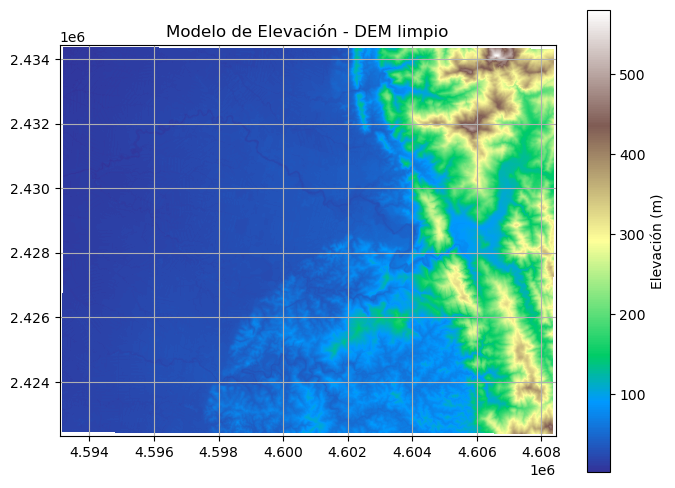

In [13]:
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    meta = src.meta
    nodata = src.nodata
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Identificar valores problemáticos
print("Valor nodata reportado en metadatos:", nodata)

# Aplicar máscara para valores absurdos
dem_clean = np.where((dem < -100) | (dem > 10000), np.nan, dem)

# Estadísticas después de filtrar
print("Máx (limpio):", np.nanmax(dem_clean))
print("Mín (limpio):", np.nanmin(dem_clean))
print("Promedio (limpio):", np.nanmean(dem_clean))

# Visualización segura
plt.figure(figsize=(8,6))
plt.imshow(dem_clean, cmap="terrain", extent=extent)
plt.title("Modelo de Elevación - DEM limpio")
plt.colorbar(label="Elevación (m)")
plt.grid(True)
plt.show()

### 2.2. Visualización de la pendiente
Esta celda carga la capa de pendiente ya calculada y recortada, filtra valores inválidos (como negativos o mayores a 100 %) y genera un mapa con gradiente de color. Se incluye una barra de porcentaje y coordenadas reales para facilitar la interpretación espacial.

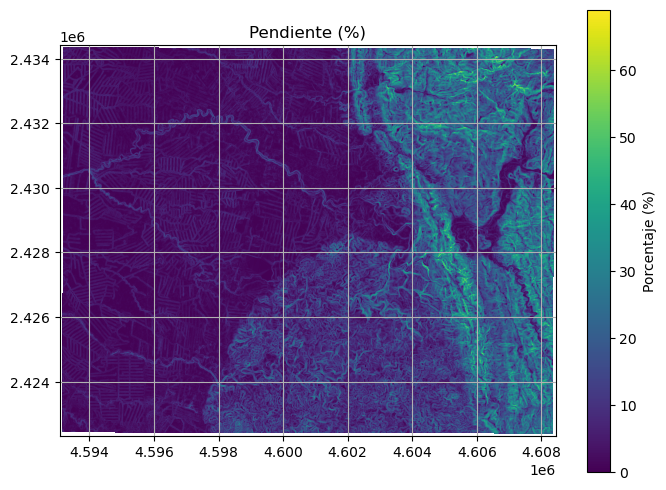

In [15]:
slope_path = "/notebooks/practica 6/DATOS RECORTADOS/pendiente_mpio.tif"

with rasterio.open(slope_path) as src:
    slope = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Filtrar valores extremos (pendiente debe estar entre 0 y 100 %)
slope_clean = np.where((slope < 0) | (slope > 100), np.nan, slope)

# Mostrar
plt.figure(figsize=(8,6))
plt.imshow(slope_clean, cmap="viridis", extent=extent)
plt.title("Pendiente (%)")
plt.colorbar(label="Porcentaje (%)")
plt.grid(True)
plt.show()


In [44]:
import matplotlib.pyplot as plt
import rasterio

# Lista de nombres y rutas
nombres = list(rutas_raster.keys())  # dict tipo {"Vias raster.tif": "output/vias_raster.tif", ...}
rutas = list(rutas_raster.values())

# Crear carpeta si no existe
os.makedirs("capas_finales", exist_ok=True)

# Crear figura
n = len(rutas)
fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

if n == 1:
    axs = [axs]

for i, path in enumerate(rutas):
    with rasterio.open(path) as src:
        data = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
    axs[i].imshow(data, cmap="viridis", extent=extent, origin="upper")
    axs[i].set_title(nombres[i].replace("_", " ").capitalize())
    axs[i].set_xlabel("Easting (m)")
    axs[i].set_ylabel("Northing (m)")
    axs[i].grid(True)

plt.tight_layout()

# Guardar visualización como imagen TIFF
fig.savefig("capas_finales/visualizacion_rasters.tiff", dpi=300, format="tiff", bbox_inches="tight")
plt.close()

print("✔ Visualización guardada como TIFF en 'capas_finales/visualizacion_rasters.tiff'")

✔ Visualización guardada como TIFF en 'capas_finales/visualizacion_rasters.tiff'


### 2.3. Exploración de la distribución de valores de pendiente

Antes de aplicar umbrales de reclasificación o restricciones, es importante explorar la distribución de las pendientes en el área de estudio. Esta celda excluye valores inválidos (negativos o nulos) y calcula estadísticas clave como mínimo, máximo, media, mediana y percentiles. También se genera un histograma para visualizar la frecuencia de valores de pendiente y detectar posibles valores atípicos.


Estadísticas del raster de pendiente
Mínimo: 0.00 %
Máximo: 69.01 %
Media: 9.72 %
Mediana: 5.62 %
Percentil 98: 36.87 %
Percentil 99.9: 51.41 %


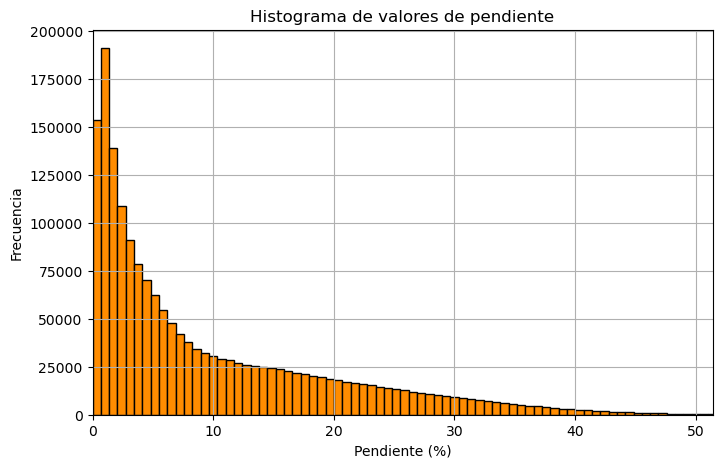

In [22]:
# Leer la capa de pendiente
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Asegúrate de que esta ruta coincide con la que definiste antes
slope_path = "/notebooks/practica 6/DATOS RECORTADOS/pendiente_mpio.tif"

with rasterio.open(slope_path) as src:
    slope = src.read(1)

# Filtrar valores no válidos (negativos o NaN)
slope_valid = slope[(slope >= 0) & np.isfinite(slope)]

# Imprimir estadísticas clave
print("Estadísticas del raster de pendiente")
print(f"Mínimo: {np.min(slope_valid):.2f} %")
print(f"Máximo: {np.max(slope_valid):.2f} %")
print(f"Media: {np.mean(slope_valid):.2f} %")
print(f"Mediana: {np.median(slope_valid):.2f} %")
print(f"Percentil 98: {np.percentile(slope_valid, 98):.2f} %")
print(f"Percentil 99.9: {np.percentile(slope_valid, 99.9):.2f} %")

# Graficar histograma
plt.figure(figsize=(8, 5))
plt.hist(slope_valid, bins=100, color="darkorange", edgecolor="black")
plt.title("Histograma de valores de pendiente")
plt.xlabel("Pendiente (%)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.xlim(0, np.percentile(slope_valid, 99.9))  # Limitar para evitar atípicos extremos
plt.show()


## 3.  Verificación y alineación del sistema de referencia espacial (CRS)

Antes de rasterizar o combinar capas, es necesario verificar que todas compartan el mismo sistema de referencia espacial (CRS). Esta celda compara el CRS de todas las capas (vectoriales y raster) con el del DEM, que se toma como referencia. Si alguna capa no coincide, se reproyecta o se deja lista para reinterpolación.


In [25]:
# Cargar CRS del DEM como referencia
with rasterio.open(dem_path) as src:
    ref_crs = src.crs
print("CRS del DEM (referencia):", ref_crs)

# === 1. VERIFICAR CRS DE CAPAS VECTORIALES ===
# Vías
vias_gdf = gpd.read_file(vias_path)
if vias_gdf.crs != ref_crs:
    print("Reproyectando 'Vías.shp' al CRS del DEM...")
    vias_gdf = vias_gdf.to_crs(ref_crs)
else:
    print("CRS de Vías ya coincide con el del DEM.")

# Buffer centros poblados
buffer_cp_gdf = gpd.read_file(buffer_poblados_path)
if buffer_cp_gdf.crs != ref_crs:
    print("Reproyectando 'buffer_centros_poblados.shp' al CRS del DEM...")
    buffer_cp_gdf = buffer_cp_gdf.to_crs(ref_crs)
else:
    print("CRS de buffer de centros poblados ya coincide con el del DEM.")

# === 2. VERIFICAR CRS DE CAPAS RASTER ===
def verificar_raster_crs(path, nombre):
    with rasterio.open(path) as r:
        if r.crs != ref_crs:
            print(f"⚠️  El CRS de '{nombre}' NO coincide con el del DEM.")
            print(f"   - CRS actual: {r.crs}")
        else:
            print(f"✔ El CRS de '{nombre}' coincide con el del DEM.")

verificar_raster_crs(slope_path, "pendiente")
verificar_raster_crs(remocion_path, "remoción en masa")
verificar_raster_crs(suelos_path, "clase de suelo")

CRS del DEM (referencia): PROJCS["MAGNA-SIRGAS 2018 / Origen-Nacional",GEOGCS["MAGNA-SIRGAS 2018",DATUM["Marco_Geocentrico_Nacional_de_Referencia_2018",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1329"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","20046"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","9377"]]
Reproyectando 'Vías.shp' al CRS del DEM...
Reproyectando 'buffer_centros_poblados.shp' al CRS del DEM...
✔ El CRS de 'pendiente' coincide con el del DEM.
⚠️  El CRS de 'remoción en masa' NO coincide con el del DEM.
   - CRS actual: PROJCS["MAGNA-SIRGAS / Colombia West zone",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Naci

In [26]:
import pandas as pd
import IPython.display as display

# Crear tabla de resumen del estado de CRS
tabla_crs = pd.DataFrame({
    "Nombre del archivo": [
        "dem_mpio.tif",
        "pendiente_mpio.tif",
        "MM_AOI.tif",
        "CLASE_SUELO_AOI.tif",
        "Vias.shp",
        "buffer_centros_poblados.shp"
    ],
    "Tipo": [
        "Raster", "Raster", "Raster", "Raster", "Vectorial", "Vectorial"
    ],
    "CRS actual (EPSG)": [
        9377, 9377, 4686, 3115, "1329 → 9377", "1329 → 9377"
    ],
    "¿Coincide con DEM (9377)?": [
        "✅ Sí", "✅ Sí", "⚠️ No", "⚠️ No", "✅ Reproyectado", "✅ Reproyectado"
    ],
    "Acción requerida": [
        "Ninguna", "Ninguna", "Reproyectar y alinear", "Reproyectar y alinear", "Ya alineado", "Ya alineado"
    ]
})

# Mostrar tabla con formato
display.display(tabla_crs.style.set_caption("Resumen del estado del CRS de todas las capas"))


,Nombre del archivo,Tipo,CRS actual (EPSG),¿Coincide con DEM (9377)?,Acción requerida
0,dem_mpio.tif,Raster,9377,✅ Sí,Ninguna
1,pendiente_mpio.tif,Raster,9377,✅ Sí,Ninguna
2,MM_AOI.tif,Raster,4686,⚠️ No,Reproyectar y alinear
3,CLASE_SUELO_AOI.tif,Raster,3115,⚠️ No,Reproyectar y alinear
4,Vias.shp,Vectorial,1329 → 9377,✅ Reproyectado,Ya alineado
5,buffer_centros_poblados.shp,Vectorial,1329 → 9377,✅ Reproyectado,Ya alineado


### 3.1. Reproyección y alineación de capas raster

Esta celda reproyecta y alinea los raster `MM_AOI.tif` (remoción en masa) y `CLASE_SUELO_AOI.tif` (clase de suelo) al mismo sistema de referencia espacial, resolución, tamaño y extensión del DEM (`EPSG:9377`). Así quedan listos para el análisis espacial.


In [27]:
from rasterio.warp import reproject, Resampling
import rasterio
import numpy as np
import os

# Crear carpeta de salida
os.makedirs("DATOS RECORTADOS/output", exist_ok=True)

# Función para reproyectar y alinear un raster al del DEM
def reproyectar_y_alinear(path_entrada, path_salida, ref_path):
    with rasterio.open(ref_path) as ref:
        dst_crs = ref.crs
        dst_transform = ref.transform
        dst_shape = (ref.height, ref.width)
        dst_meta = ref.meta.copy()

    with rasterio.open(path_entrada) as src:
        src_data = src.read(1)
        aligned = np.empty(dst_shape, dtype=src_data.dtype)

        reproject(
            source=src_data,
            destination=aligned,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        dst_meta.update({
            "height": dst_shape[0],
            "width": dst_shape[1],
            "transform": dst_transform,
            "crs": dst_crs
        })

        with rasterio.open(path_salida, "w", **dst_meta) as dst:
            dst.write(aligned, 1)

# Aplicar a tus capas
reproyectar_y_alinear(remocion_path, "output/remocion_alineado.tif", dem_path)
reproyectar_y_alinear(suelos_path, "output/suelos_alineado.tif", dem_path)

print("✔ Remoción en masa y suelos alineados al CRS y extensión del DEM.")

✔ Remoción en masa y suelos alineados al CRS y extensión del DEM.


## 4. Rasterización de capas vectoriales

Para integrar datos vectoriales en el análisis espacial basado en ráster, es necesario convertir estas capas al formato raster. Esta sección realiza los siguientes pasos clave, utilizando como referencia espacial el Modelo de Elevación Digital (DEM):

1. **Cargar parámetros de referencia**: Se extraen del DEM los parámetros de transformación espacial (`transform`), tamaño (`shape`) y sistema de referencia de coordenadas (`CRS`) para asegurar que todos los rásters resultantes estén alineados espacialmente con el área de estudio.

2. **Definir una función de rasterización**: Se implementa una función reutilizable que convierte cualquier `GeoDataFrame` en un raster binario, asignando el valor `1` a las celdas que contienen geometría y `0` al resto.

3. **Aplicar la función a las capas vectoriales**:
   - `Vías.shp`: red vial como infraestructura lineal de transporte.
   - `buffer_centros_poblados.shp`: zona de proximidad a centros poblados.

Los rásters resultantes se guardan como:
- `output/vias_raster.tif`
- `output/buffer_centros_poblados_raster.tif`

Estas capas rasterizadas están alineadas y listas para los siguientes pasos de estandarización y combinación dentro del flujo de trabajo del Análisis Multicriterio Espacial (SMCA).


In [31]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import os

# Crear carpeta de salida si no existe
os.makedirs("output", exist_ok=True)

# 1. Cargar DEM como plantilla
with rasterio.open(dem_path) as ref:
    ref_meta = ref.meta.copy()
    out_shape = (ref.height, ref.width)
    out_transform = ref.transform
    out_crs = ref.crs

# 2. Cargar capas vectoriales ya reproyectadas
vias_gdf = gpd.read_file(vias_path).to_crs(out_crs)
buffer_gdf = gpd.read_file(buffer_poblados_path).to_crs(out_crs)

# 3. Función para rasterizar binario (vías, etc.)
def rasterizar_binario(gdf, out_raster_path, valor=1):
    raster = rasterize(
        [(geom, valor) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=out_transform,
        fill=0,
        dtype="uint8"
    )
    meta = ref_meta.copy()
    meta.update({
        "driver": "GTiff",
        "height": out_shape[0],
        "width": out_shape[1],
        "transform": out_transform,
        "crs": out_crs,
        "count": 1,
        "dtype": "uint8",
        "nodata": 0
    })
    with rasterio.open(out_raster_path, "w", **meta) as dst:
        dst.write(raster, 1)

# 4. Función para rasterizar categórico (por columna)
def rasterizar_categorico(gdf, columna_valor, out_raster_path):
    shapes = [(geom, val) for geom, val in zip(gdf.geometry, gdf[columna_valor])]
    raster = rasterize(
        shapes,
        out_shape=out_shape,
        transform=out_transform,
        fill=0,
        dtype="uint8"
    )
    meta = ref_meta.copy()
    meta.update({
        "driver": "GTiff",
        "height": out_shape[0],
        "width": out_shape[1],
        "transform": out_transform,
        "crs": out_crs,
        "count": 1,
        "dtype": "uint8",
        "nodata": 0
    })
    with rasterio.open(out_raster_path, "w", **meta) as dst:
        dst.write(raster, 1)

# 5. Aplicar funciones
rasterizar_binario(vias_gdf, "output/vias_raster.tif")
rasterizar_categorico(buffer_gdf, "Raterclase", "output/buffer_centros_poblados_raster.tif")

print("✔ Capas vectoriales rasterizadas y guardadas.")

✔ Capas vectoriales rasterizadas y guardadas.


### 4.1. Visualización de capas rasterizadas con coordenadas reales

This section visualises the rasterised outputs of roads, rivers, and protected areas. 

The axes are labelled in real-world map units (metres), and the grid provides spatial reference.


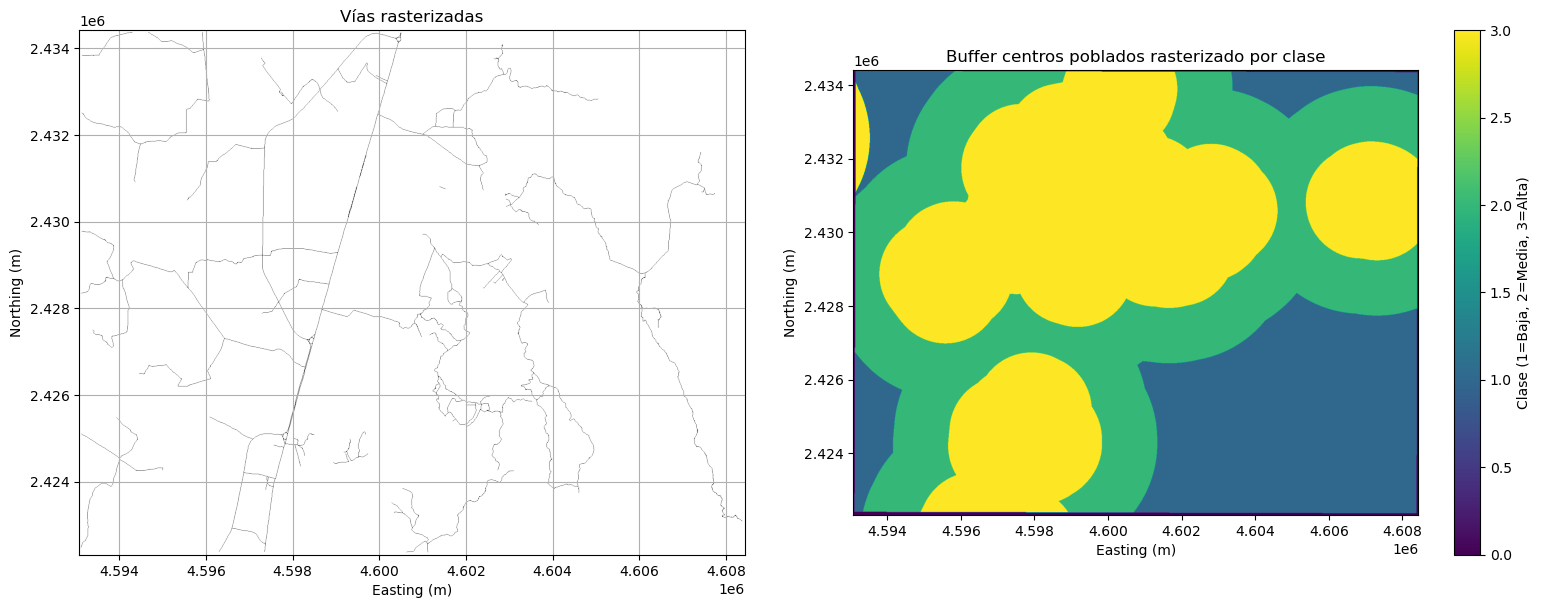

In [32]:
import matplotlib.pyplot as plt
import rasterio

# Leer raster de referencia (DEM) para obtener el extent
with rasterio.open(dem_path) as ref:
    transform = ref.transform
    out_shape = (ref.height, ref.width)
    extent = [
        transform * (0, 0),  # top-left
        transform * (out_shape[1], out_shape[0])  # bottom-right
    ]
    xmin, ymax = extent[0]
    xmax, ymin = extent[1]
    extent = [xmin, xmax, ymin, ymax]

# Cargar los raster ya generados
vias_raster = rasterio.open("output/vias_raster.tif").read(1)
buffer_raster = rasterio.open("output/buffer_centros_poblados_raster.tif").read(1)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Vías
im0 = axs[0].imshow(vias_raster, cmap="Greys", extent=extent, origin="upper")
axs[0].set_title("Vías rasterizadas")
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")
axs[0].grid(True)

# Buffer con clases
im1 = axs[1].imshow(buffer_raster, cmap="viridis", extent=extent, origin="upper")
axs[1].set_title("Buffer centros poblados rasterizado por clase")
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")
cbar = plt.colorbar(im1, ax=axs[1])
cbar.set_label("Clase (1=Baja, 2=Media, 3=Alta)")

plt.tight_layout()
plt.show()


### 5.2. Guardar todas las capas (rasterizadas y ya raster)

The binary rasters for roads, rivers, and protected areas will now be saved as GeoTIFF files.  
They share the same extent, resolution, and CRS as the reprojected DEM (EPSG:9377).


In [46]:
import os
import rasterio
import shutil

# Crear carpeta de salida si no existe
os.makedirs("DATOS RECORTADOS/capas_finales", exist_ok=True)

# Rutas de entrada de las capas raster ya generadas
rutas_raster = {
    "vias_raster.tif": "output/vias_raster.tif",
    "buffer_centros_poblados_raster.tif": "output/buffer_centros_poblados_raster.tif",
    "pendiente.tif": "DATOS RECORTADOS/pendiente_mpio.tif",  # ejemplo de raster ya existente
    "remocion_masa.tif": "output/remocion_alineado.tif",  # ejemplo de raster ya existente
    "suelo_clase.tif": "output/suelos_alineado.tif"  # ejemplo de raster ya existente
}

# Copiar a carpeta final
for nombre, ruta in rutas_raster.items():
    destino = os.path.join("DATOS RECORTADOS/capas_finales", nombre)
    shutil.copy(ruta, destino)
    print(f"✔ Guardado: {nombre} en 'capas_finales/'")


✔ Guardado: vias_raster.tif en 'capas_finales/'
✔ Guardado: buffer_centros_poblados_raster.tif en 'capas_finales/'
✔ Guardado: pendiente.tif en 'capas_finales/'
✔ Guardado: remocion_masa.tif en 'capas_finales/'
✔ Guardado: suelo_clase.tif en 'capas_finales/'


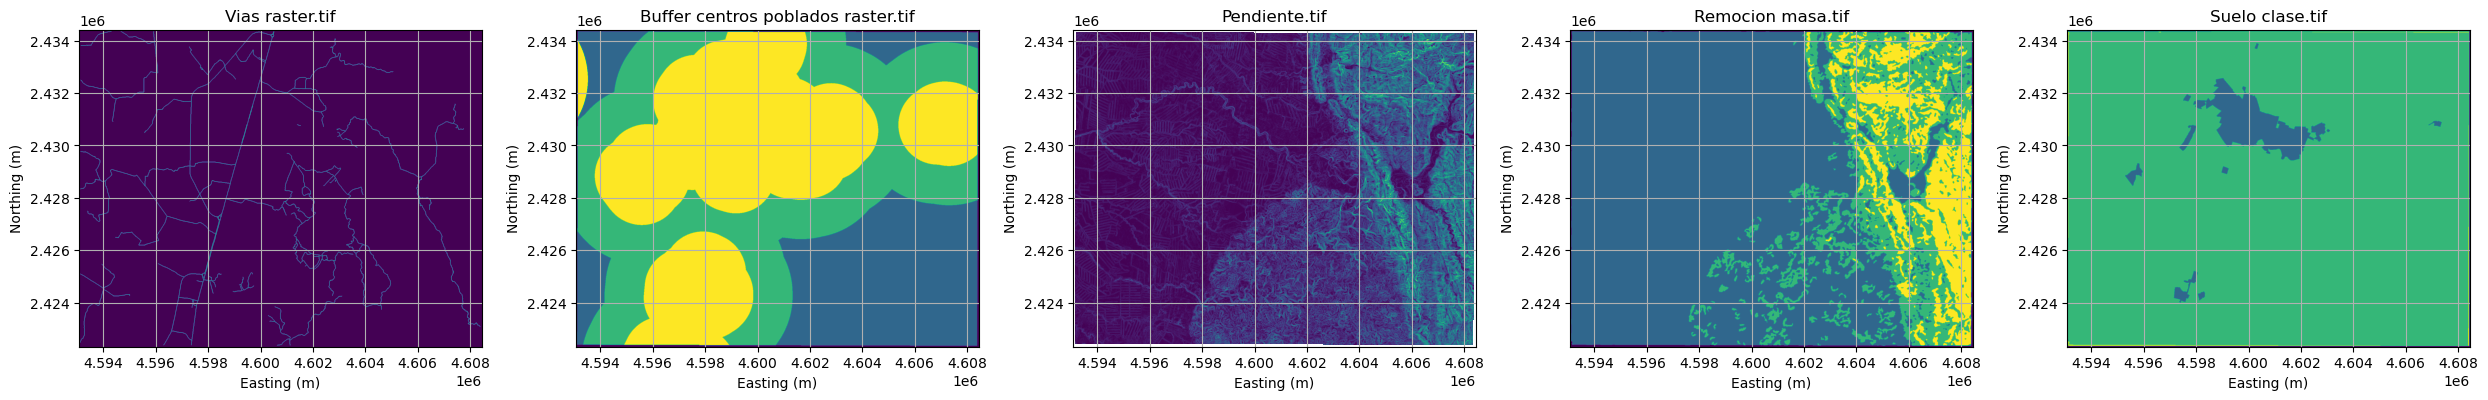

In [48]:
#import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Lista de capas finales a visualizar
nombres = list(rutas_raster.keys())
rutas = list(rutas_raster.values())

# Crear figura con subplots
n = len(rutas)
fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axs = [axs]  # para mantener iterable

for i, path in enumerate(rutas):
    with rasterio.open(path) as src:
        data = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        # Aplicar limpieza solo para la capa de pendiente
        if "pendiente" in nombres[i].lower():
            data = np.where((data < 0) | (data > 100), np.nan, data)

        axs[i].imshow(data, cmap="viridis", extent=extent, origin="upper")
        axs[i].set_title(nombres[i].replace("_", " ").capitalize())
        axs[i].set_xlabel("Easting (m)")
        axs[i].set_ylabel("Northing (m)")
        axs[i].grid(True)

plt.tight_layout()
plt.show()
